In [1]:
import os
import sys 
import glob 

import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn 
import torch.utils.data as data
from torchvision import models,transforms

/home/ksuga/fiveprime/.venv/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
labels = pd.read_csv("train_label.csv",index_col=0)
val = labels.iloc[:100]
train = labels.iloc[100:]

u,c = np.unique(val["label"].values,return_counts=True)
print(u,c)
u,c = np.unique(train["label"].values,return_counts=True)
print(u,c)

[0 1] [50 50]
[0] [200]


In [3]:
class Dataset(data.Dataset):

    def __init__(self,data,transform=None):
        self.dataset=data # [path,label]のpdDF
        self.transform = transform
        
    def __len__(self):
        return self.dataset.shape[0]
    
    def __getitem__(self,idx):
        
        img = Image.open(self.dataset.iloc[idx]["path"])
        img = img.convert("RGB")
        #img = cv2.imread(self.dataset.iloc[idx]["path"])
        img = self.transform(img)
        

        return img,self.dataset.iloc[idx]["label"]

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

train_dataset = Dataset(train,transform)
val_dataset = Dataset(val,transform)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=8,shuffle=True,num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=1,shuffle=False,num_workers=2)

dataset_dict = {"train":train_dataset,"test":val_dataset}
dataloaders_dict = {"train":train_loader,"test":val_loader}


In [12]:
"""
model = models.resnet50(pretrained=True)
model.fc = nn.Identity()

device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model = nn.DataParallel(model)
"""
from efficientnet_pytorch import EfficientNet
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNet.from_pretrained("efficientnet-b7").to(device)
model = nn.DataParallel(model)



Loaded pretrained weights for efficientnet-b7


In [13]:
train_features=[]
for input,_ in tqdm(train_loader):
    input = input.to(device)
    output = model(input)
    train_features.extend(output.detach().cpu())

tf_tensor = torch.cat(train_features).reshape(len(train_features),*train_features[0].shape)


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


In [15]:
k=2
val_labels = []
d_scores = [] 
val_features=[]
for input,l in val_dataset:
    input = torch.unsqueeze(input,0).to(device) # 1,3,224,224
    output = model(input).detach().cpu()
    val_features.extend(output)
    dist = torch.cdist(tf_tensor,output,p=2)
    dist = dist.numpy().reshape(-1)
    near_args = dist.argsort()[:k]
    tmp_score = np.average(dist[near_args]**2)

    val_labels.append(l)
    d_scores.append(tmp_score)
    


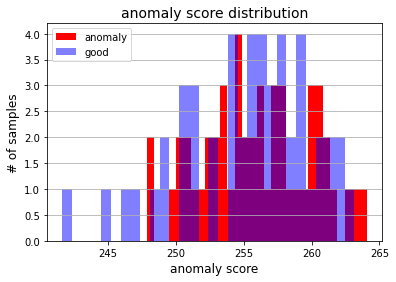

In [18]:
import matplotlib.pyplot as plt
plt.hist(d_scores[:50],bins=30,color="r",label="anomaly")
plt.hist(d_scores[50:],bins=30,color="b",alpha=0.5,label="good")
plt.legend()
plt.title("anomaly score distribution",fontsize=14)
plt.xlabel("anomaly score",fontsize=12)
plt.ylabel("# of samples",fontsize=12)
plt.grid(axis="y")
plt.savefig("dn2_efficientnet_scoredist")


## PCA

In [182]:
from sklearn.decomposition import PCA
numpy_feature = tf_tensor.numpy()

In [196]:
pca = PCA(n_components=2)
pca.fit(numpy_feature)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [198]:
valf_numpy = torch.cat(val_features).reshape(len(val_features),*val_features[0].shape).numpy()

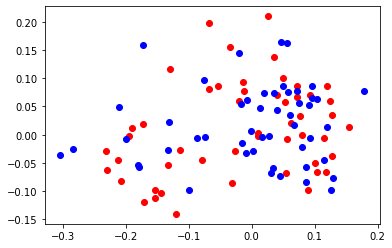

In [205]:
anom = pca.transform(valf_numpy[:50])
nom = pca.transform(valf_numpy[50:])

plt.scatter(anom[:,0],anom[:,1],color="r")
plt.scatter(nom[:,0],nom[:,1],color="b")

In [207]:
import umap

In [212]:
decom = umap.UMAP(random_state=0)
decom.fit(numpy_feature)
emb = decom.transform(valf_numpy)


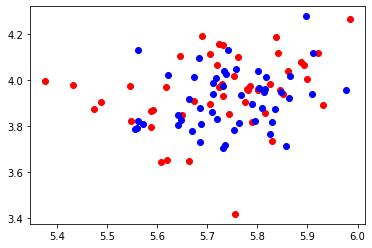

In [213]:
plt.scatter(emb[:50,0],emb[:50,1],color="r")
plt.scatter(emb[50:,0],emb[50:,1],color="b")